In [1]:
import pandas as pd
import numpy as np

In [2]:
electricity = pd.read_csv('Electric_Production.csv')
electricity

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


In [3]:
electricity = electricity.rename(columns={'IPG2211A2N':'Demand','DATE':'Date'})
electricity['Date'] = pd.to_datetime(electricity['Date'])


In [4]:
electricity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    397 non-null    datetime64[ns]
 1   Demand  397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


In [5]:
electricity.set_index('Date',inplace=True)

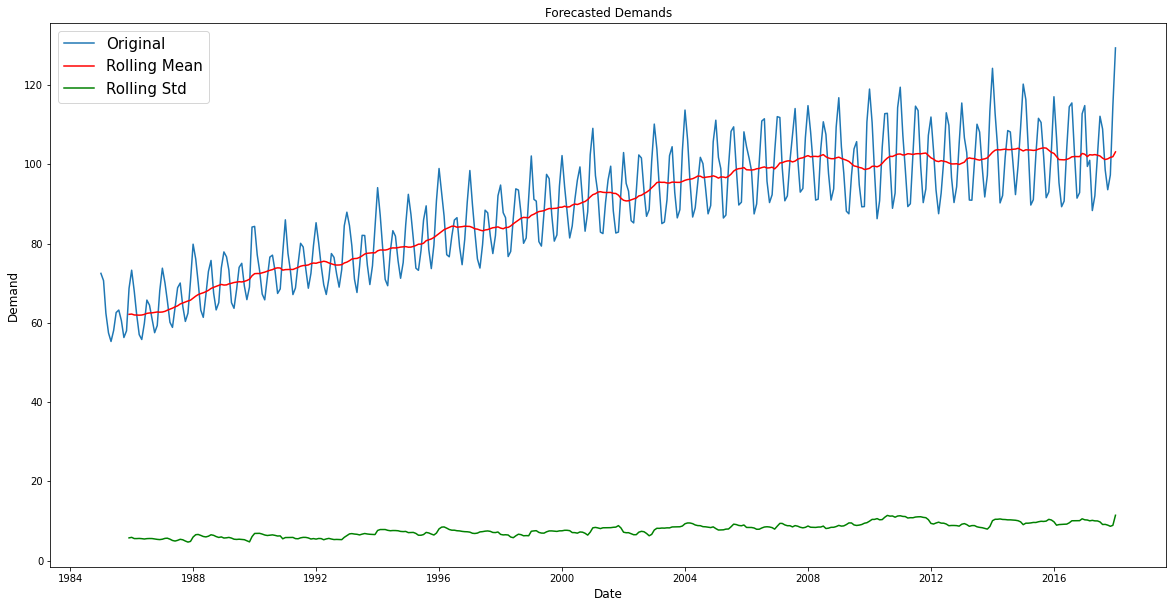

In [6]:
import matplotlib.pyplot as plt

rolling_mean = electricity.rolling(window=12).mean()
rolling_std = electricity.rolling(window=12).std()
plt.figure(figsize=(20,10))
plt.plot(electricity,label='Original')
plt.plot(rolling_mean,color='red',label='Rolling Mean')
plt.plot(rolling_std,color='green',label='Rolling Std')
plt.xlabel('Date',size=12)
plt.ylabel('Demand',size=12)
plt.title('Forecasted Demands',size=12)
plt.legend(loc="best",fontsize=15)
plt.show()



<Figure size 1440x720 with 0 Axes>

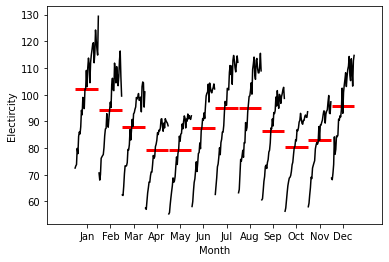

In [28]:
from statsmodels.graphics.tsaplots import month_plot
plt.figure(figsize=(20,10))
month_plot(electricity)
plt.xlabel('Month')
plt.ylabel('Electircity')
plt.show()

2023-02-24 12:15:54,012 [19104] WARNING  py.warnings:109: [JupyterRequire] c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(



<AxesSubplot:xlabel='Date'>

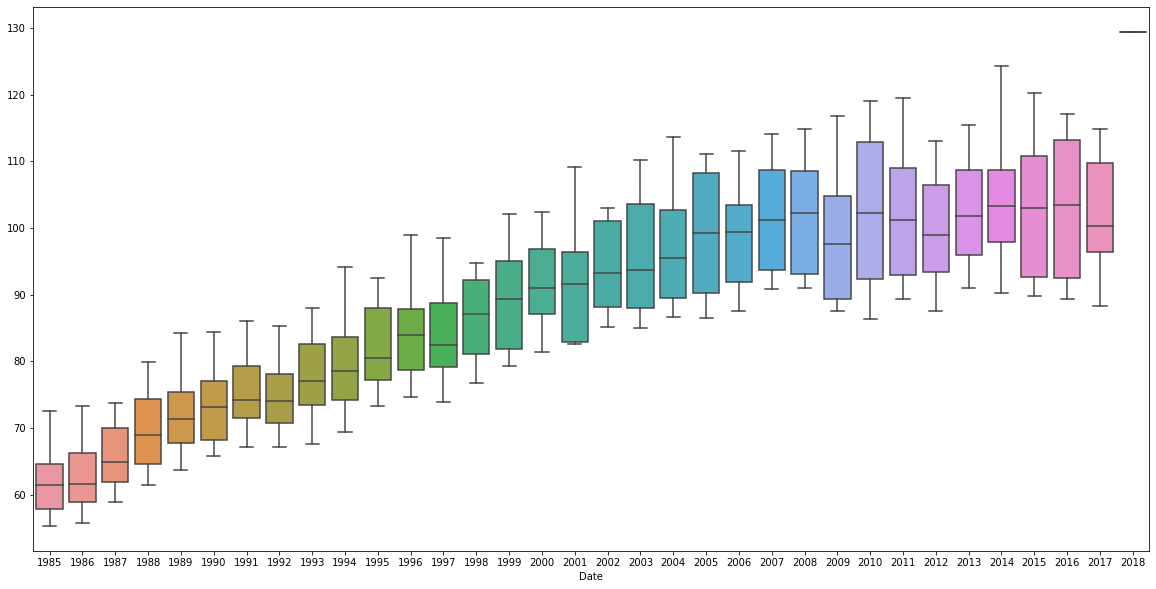

In [41]:
import seaborn as sns
fig,ax = plt.subplots(figsize=(20,10))
sns.boxplot(electricity.index.year,electricity.values[:,0])

2023-02-24 12:18:51,833 [19104] WARNING  py.warnings:109: [JupyterRequire] c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(



<AxesSubplot:xlabel='Date'>

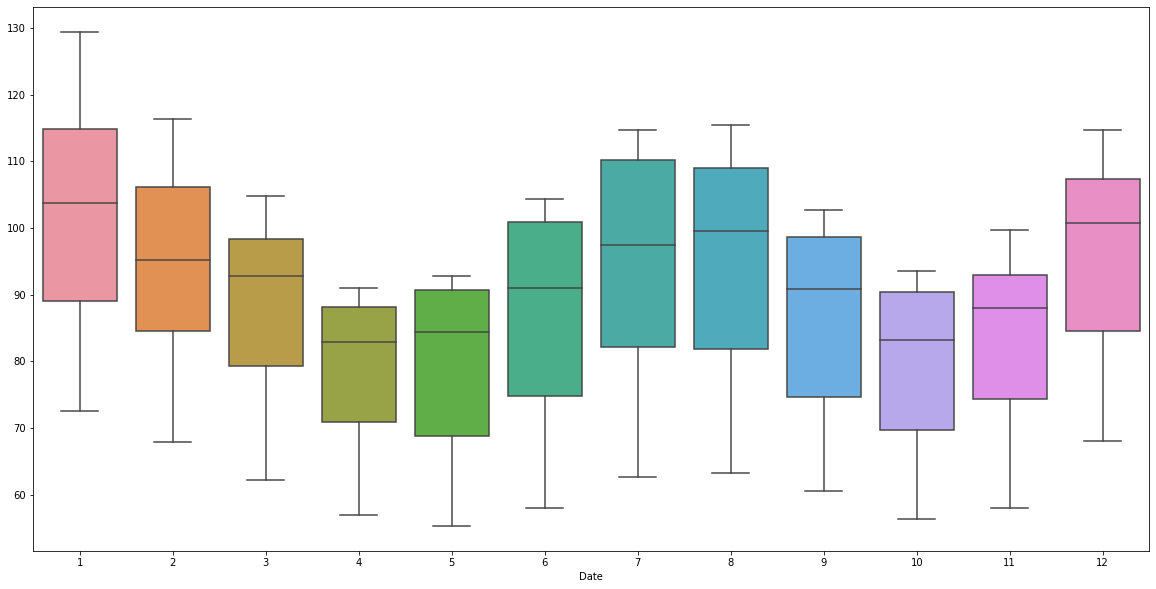

In [50]:
import seaborn as sns
fig,ax = plt.subplots(figsize=(20,10))
sns.boxplot(electricity.index.month,electricity.values[:,0])

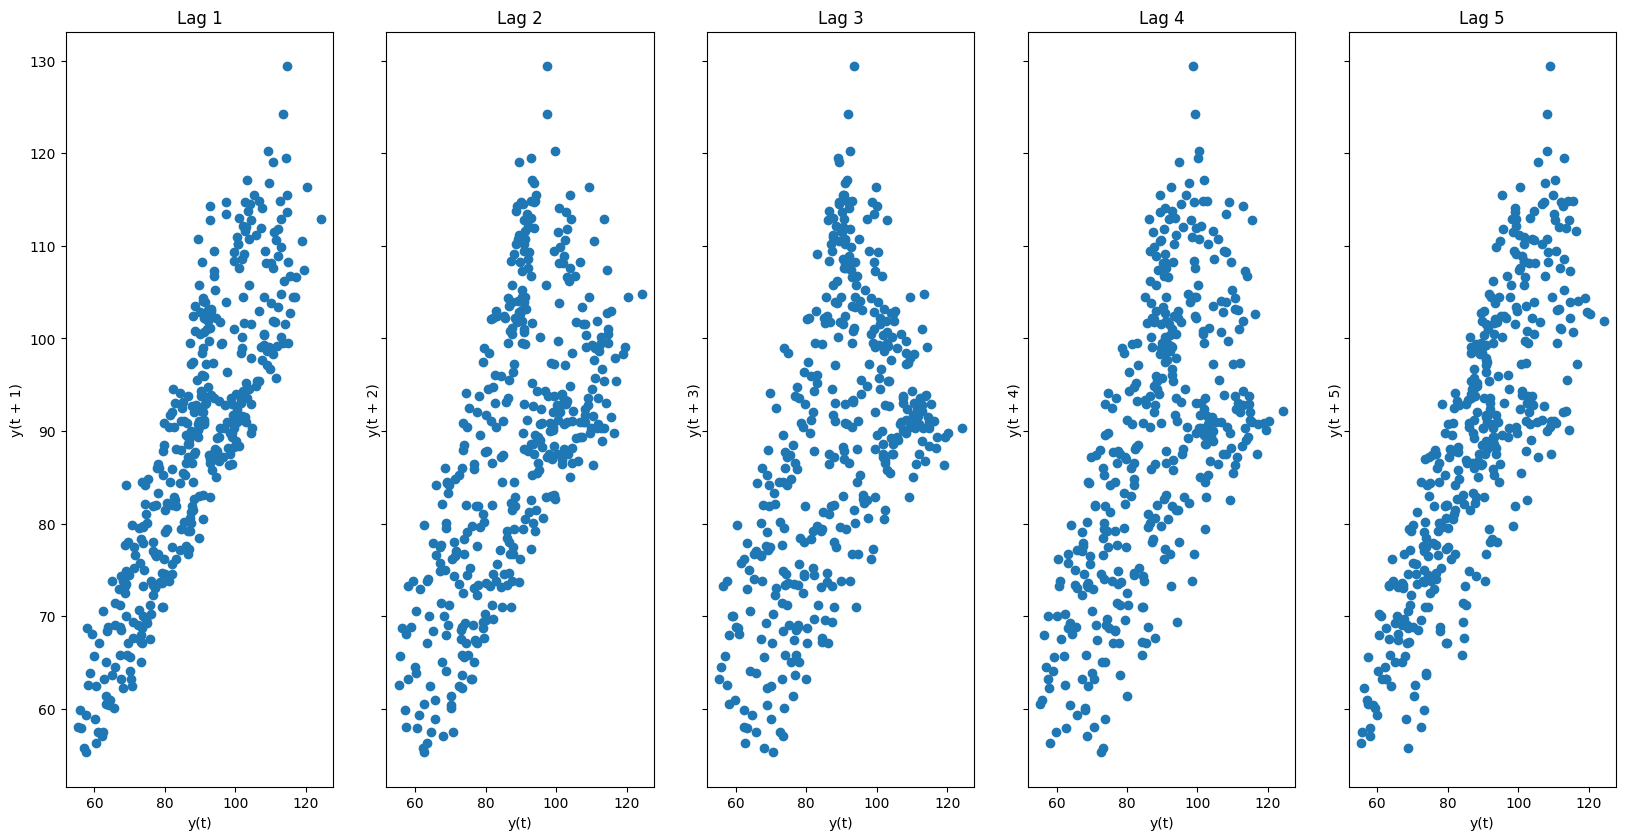

In [72]:
from pandas.plotting import lag_plot
#fig,ax = plt.subplots(figsize=(20,10))
fig, axes = plt.subplots(1, 5, figsize=(20,10), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:5]):
    lag_plot(electricity['Demand'], lag=i+1, ax=ax)
    ax.set_title('Lag ' + str(i+1))


In [52]:
#There seems to be high correlation between previous time periods

2023-02-24 17:56:50,271 [19104] WARNING  py.warnings:109: [JupyterRequire] c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(



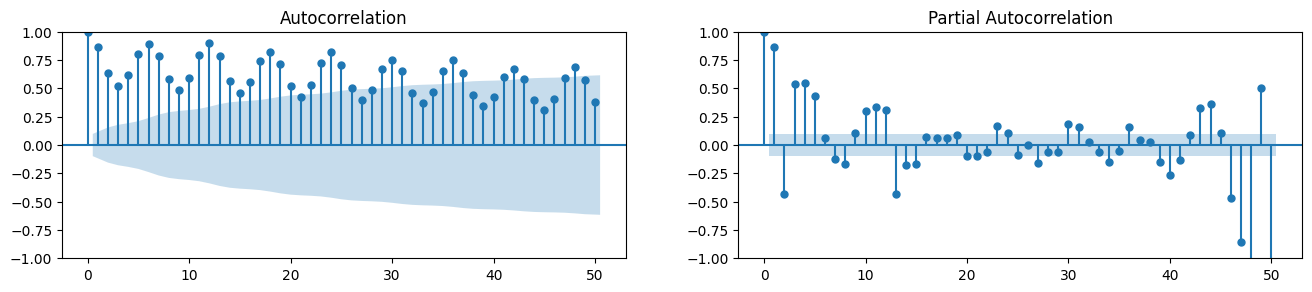

In [73]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(electricity.Demand, lags=50, ax=axes[0])
plot_pacf(electricity.Demand, lags=50, ax=axes[1])
plt.show()

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [8]:
decomp_data = seasonal_decompose(electricity['Demand'],period=12)

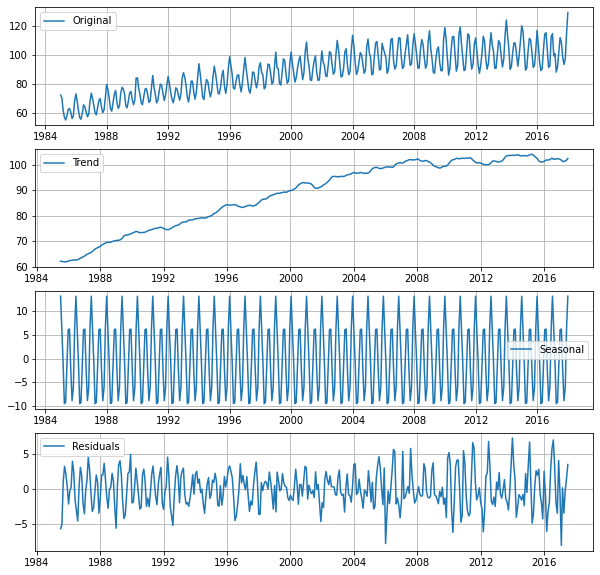

In [9]:
fig,ax = plt.subplots(4,1,figsize=(10,10))
ax[0].plot(decomp_data.observed,label='Original')
ax[1].plot(decomp_data.trend,label='Trend')
ax[2].plot(decomp_data.seasonal,label='Seasonal')
ax[3].plot(decomp_data.resid,label='Residuals')
ax[0].legend()
ax[0].grid(True)
ax[1].legend()
ax[1].grid(True)
ax[2].legend()
ax[2].grid(True)
ax[3].legend(loc='best')
ax[3].grid(True)
plt.show()

<b> There seems to be an upward trend and a sasonal pattern in the data <b>

Perform the adf fuller test for the above graph. Null hypothesis will be that the graph is not stationary. We need to convert it into a stationary graph

In [128]:
from statsmodels.tsa.stattools import adfuller
def adf_fuller(df,wind=12):
    rolling_mean= df.rolling(window=wind).mean()
    rolling_std = df.rolling(window=wind).std()
    plt.figure(figsize=(20,10))
    plt.plot(df,label='Original')
    plt.plot(rolling_mean,color='red',label='Rolling Mean')
    plt.plot(rolling_std,color='green',label='Rolling Std')
    plt.xlabel('Date',size=12)
    plt.ylabel('Demand',size=12)
    plt.title('Forecasted Demands',size=12)
    plt.legend(loc="best",fontsize=15)
    plt.show()
    
    res =  adfuller(df,autolag='AIC')
    return pd.Series(res[0:5],index=['Statistic','P-Value','Lags Used','Observations','Critical Values'])
    
    


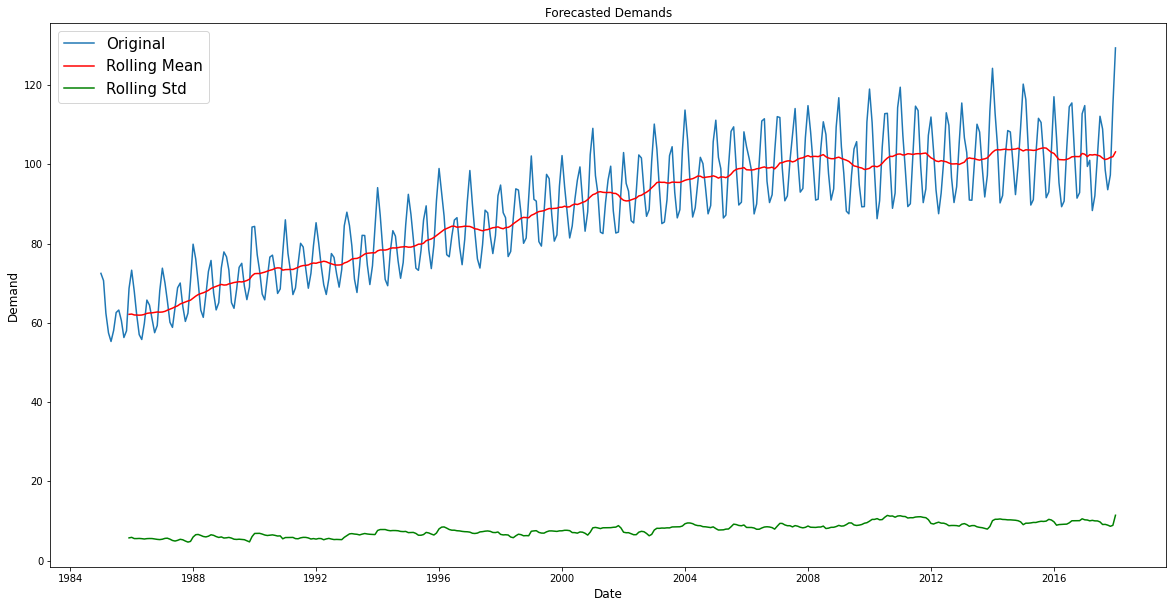

In [129]:
res = adf_fuller(electricity)

In [12]:
res

Statistic                                                   -2.25699
P-Value                                                     0.186215
Lags Used                                                         15
Observations                                                     381
Critical Values    {'1%': -3.4476305904172904, '5%': -2.869155980...
dtype: object

We see that p value > 0.05, so this is not significant and we cannot reject the null hypothesis of the graph being non stationary. We need to make it stationary

In [13]:
!pip install pmdarima


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import pmdarima as pm

In [15]:
pm.auto_arima(electricity['Demand'], seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  397
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -925.985
Date:                              Fri, 24 Feb 2023   AIC                           1863.971
Time:                                      11:42:51   BIC                           1887.859
Sample:                                  01-01-1985   HQIC                          1873.434
                                       - 01-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3637      0.092      3.956      0.000       0.184       0.544
ma.L1         -0.7368      0.091     -8.090      0.000      -0.915      -0.558
ma.L2         -0.2008      0.079     -2.528      0.011      -0.357      -0.045
ar.S.L12       0.9969      0.003    382.794      0.000       0.992       1.002
ma.S.L12      -0.7724      0.036    -21.307      0.000      -0.843      -0.701
sigma2         5.7411      0.325     17.672      0.000       5.104       6.378
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                28.99
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               3.05   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
## The sarima model chosen is 1,1,2 * (1,0,1,12)

train = electricity[:len(electricity)-12]
test = electricity[len(electricity)-12:]

In [17]:
train

,Demand
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2016-09-01,102.7637
2016-10-01,91.4867
2016-11-01,92.8900


In [18]:
test

,Demand
Date,
2017-02-01,99.4901
2017-03-01,101.0396
2017-04-01,88.3530
2017-05-01,92.0805
2017-06-01,102.1532
2017-07-01,112.1538
2017-08-01,108.9312
2017-09-01,98.6154
2017-10-01,93.6137


In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
arima_model = SARIMAX(train['Demand'],order=(1,1,2),seasonal_order=(1,0,1,12))


2023-02-24 11:42:51,901 [19104] WARNING  py.warnings:109: [JupyterRequire] c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)

2023-02-24 11:42:51,910 [19104] WARNING  py.warnings:109: [JupyterRequire] c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



In [20]:
arima_res = arima_model.fit()
arima_res.summary()

2023-02-24 11:42:51,931 [19104] WARNING  py.warnings:109: [JupyterRequire] c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               Demand   No. Observations:                  385
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -883.713
Date:                              Fri, 24 Feb 2023   AIC                           1779.427
Time:                                      11:42:52   BIC                           1803.130
Sample:                                  01-01-1985   HQIC                          1788.829
                                       - 01-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3643      0.102      3.568      0.000       0.164       0.564
ma.L1         -0.7489      0.104     -7.234      0.000      -0.952      -0.546
ma.L2         -0.1872      0.091     -2.052      0.040      -0.366      -0.008
ar.S.L12       0.9956      0.003    297.304      0.000       0.989       1.002
ma.S.L12      -0.7521      0.037    -20.344      0.000      -0.825      -0.680
sigma2         5.3380      0.329     16.219      0.000       4.693       5.983
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                17.07
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               2.69   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
arima_pred = arima_res.predict(start = len(train), end = len(electricity)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2017-02-01    107.430052
2017-03-01     99.875431
2017-04-01     90.218541
2017-05-01     91.987524
2017-06-01    103.067971
2017-07-01    112.195768
2017-08-01    111.831655
2017-09-01    101.291984
2017-10-01     92.362479
2017-11-01     95.431069
2017-12-01    109.832817
2018-01-01    117.748375
Freq: MS, Name: ARIMA Predictions, dtype: float64

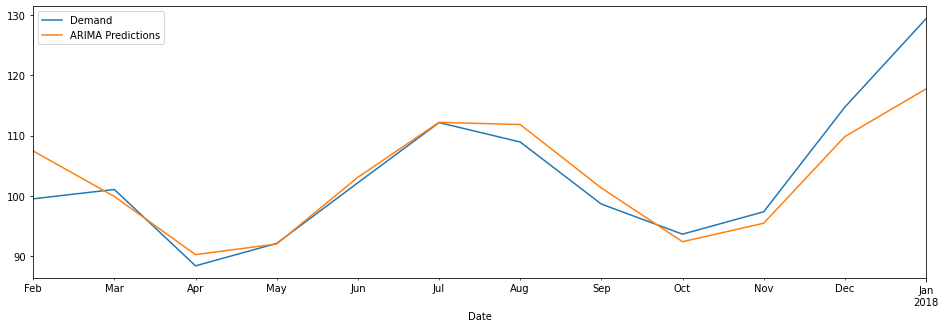

In [22]:
test['Demand'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [23]:
from statsmodels.tools.eval_measures import rmse
arima_rmse_error = rmse(test['Demand'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = electricity['Demand'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 20.772065301257573
RMSE Error: 4.557638127501741
Mean: 88.84721763224182


### The above process was done without tuning any parameters. Let's try to make the data stationary and then predict the values

In [130]:
electricity_first_order = electricity.Demand - electricity.Demand.diff(periods=12)
electricity_first_order.dropna(inplace=True)

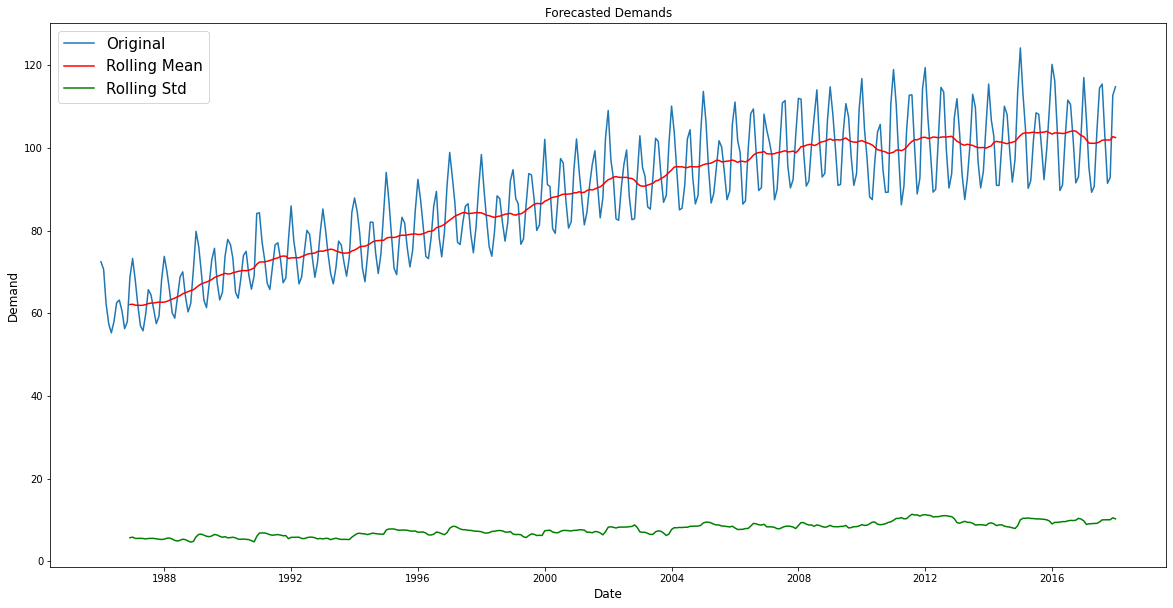

Statistic                                                  -2.459294
P-Value                                                     0.125695
Lags Used                                                         15
Observations                                                     369
Critical Values    {'1%': -3.448196541708585, '5%': -2.8694046837...
dtype: object

In [131]:
res_first_order = adf_fuller(electricity_first_order)
res_first_order

Differencing still didn't yield the graph to be stationary so we will try to transform this into log and then do the differing

In [144]:
electricity_log = np.log(electricity).diff(periods=1)

In [145]:
electricity_log1 = electricity_log.dropna()


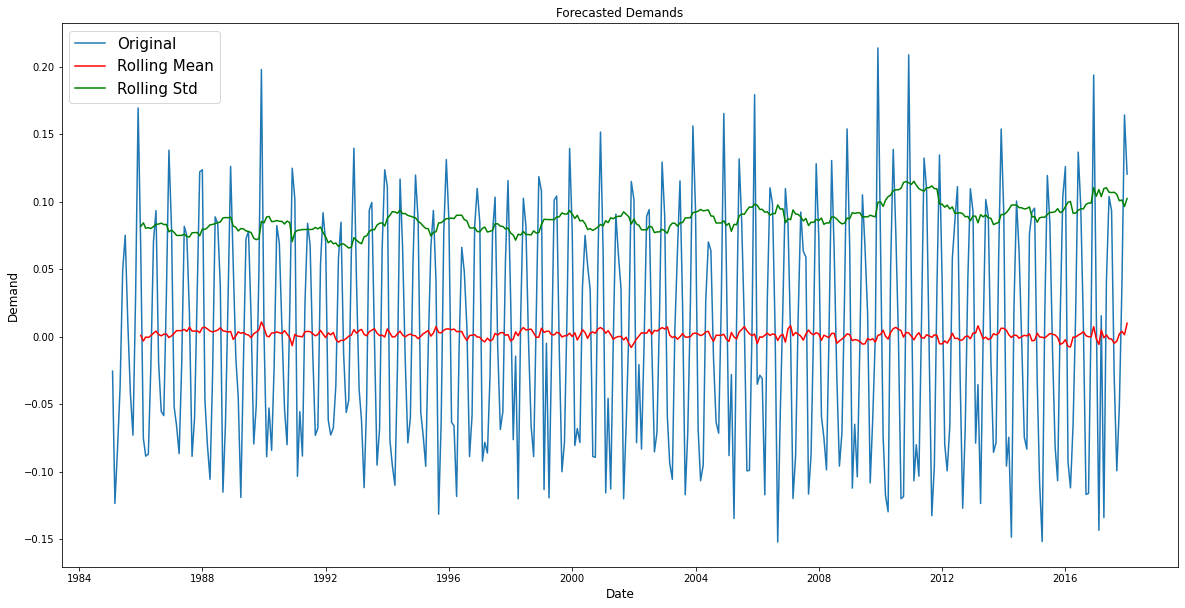

Statistic                                                  -6.748333
P-Value                                                          0.0
Lags Used                                                         14
Observations                                                     381
Critical Values    {'1%': -3.4476305904172904, '5%': -2.869155980...
dtype: object

In [146]:
res_first_order_log = adf_fuller(electricity_log1)
res_first_order_log

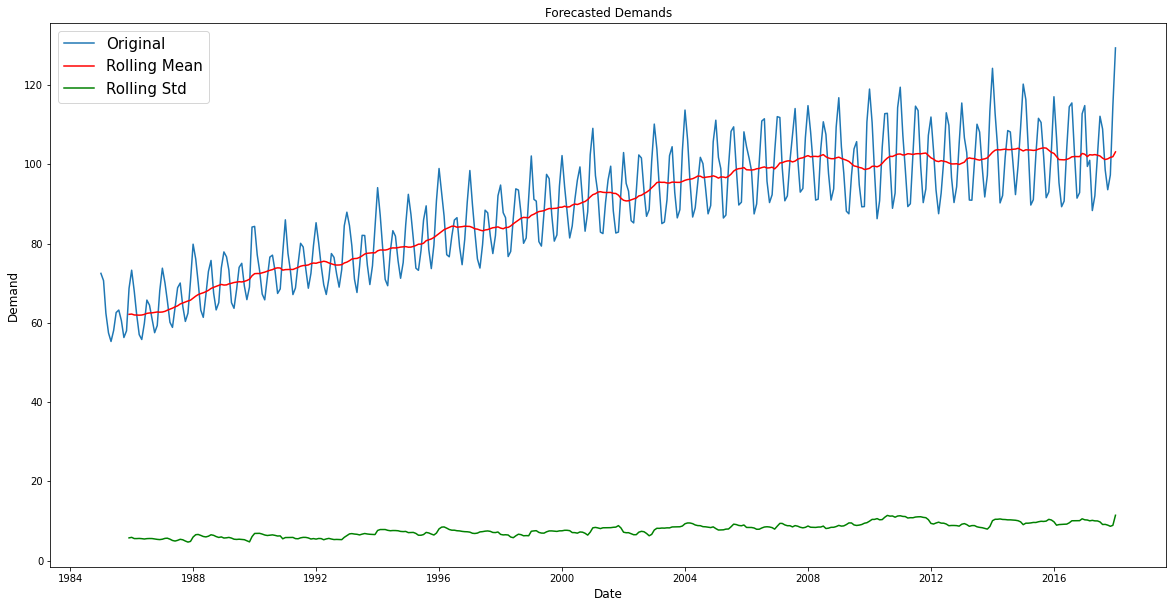

In [117]:
res = adf_fuller(electricity)

In [119]:
electricity

,Demand
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


In [126]:
electricity_log1

,Demand
Date,
1986-01-01,0.010980
1986-02-01,-0.038734
1986-03-01,-0.003659
1986-04-01,-0.007659
1986-05-01,0.008973
...,...
2017-09-01,-0.041205
2017-10-01,0.022983
2017-11-01,0.046752
